<a href="https://colab.research.google.com/github/hchaparov/Dynamic_Pricing_MARL/blob/main/2A_basket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install swig
!pip install "pettingzoo"
!pip install "stable-baselines3"
!pip install "supersuit"
!pip install pymunk
!pip install pyvirtualdisplay imageio[ffmpeg]
!apt-get install -y xvfb
!pip install tensorboard
!pip install pillow
!pip install multi_agent_ale_py
!pip install autorom
!pip install moviepy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (572 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [2]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms
	/usr/local/lib/python3.10/dist-packages/multi_agent_ale_py/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.10/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.10/dist-packages/multi_agent_ale_py/roms/adventure.bin
Installed /usr/local/lib/python3.10/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.10/dist-packages/multi_agent_ale_py/roms/air_raid.bin
Installed /usr/local/lib/python3.10/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.10/dist-packages/multi_agent_ale_py/roms/alien.bin
Installed /usr/local/lib/python3.10/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.10/dist-packages/multi_agent_ale_py/roms/amidar.bin
Installed /usr/local/lib/python3.10/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.10/dist-packages/multi_

In [3]:
from __future__ import annotations

from pyvirtualdisplay import Display
import imageio
import numpy as np
import glob
import os
import time
import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from pettingzoo.atari import basketball_pong_v3
from PIL import Image
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, BaseCallback
from stable_baselines3.common.logger import configure
from moviepy.editor import ImageSequenceClip
from stable_baselines3.common.vec_env import VecVideoRecorder
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

log_dir = "/content/drive/MyDrive/2A_basket_ppo/"
os.makedirs(log_dir, exist_ok=True)

temp_eval_log_dir = "/content/drive/My Drive/2A_basket_ppo/tmp"
os.makedirs(temp_eval_log_dir, exist_ok=True)

n_training_envs = 4

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



Mounted at /content/drive


In [4]:
def train_basket_supersuit(env_fn, steps: int = 200_000, seed: int | None = 0, **env_kwargs):
    # Train a single model to play as each agent in a parallel environment
    env = env_fn.parallel_env(**env_kwargs)
    env = ss.color_reduction_v0(env, mode='full')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4)

    env.reset(seed = seed)

    eval_env = ss.pettingzoo_env_to_vec_env_v1(env)
    eval_env = ss.concat_vec_envs_v1(eval_env, n_training_envs, num_cpus=2, base_class="stable_baselines3")

    env = ss.pettingzoo_env_to_vec_env_v1(env)
    env = ss.concat_vec_envs_v1(env, n_training_envs, num_cpus=2, base_class="stable_baselines3")


    print(f"Starting training")

    # Create callback that evaluates agent for 10 episodes every 20000 training environment steps.
    eval_callback = EvalCallback(eval_env, best_model_save_path=temp_eval_log_dir,
                             log_path=temp_eval_log_dir, eval_freq=max(20000 // n_training_envs, 1),
                             n_eval_episodes=10, deterministic=True,
                             render=False)

    if os.path.exists("/content/drive/MyDrive/2A_basket_ppo/ppo_model_100k.zip"):
      model = PPO.load("/content/drive/MyDrive/2A_basket_ppo/ppo_model_100k", env=env)
    else:
      model = PPO(
            CnnPolicy,
            env,
            learning_rate=3e-4,  # Lower learning rate for stable training
            n_steps=2048,        # Increase number of steps per update
            batch_size=64,       # Batch size for each update
            n_epochs=10,         # Number of epochs to optimize the surrogate loss
            gamma=0.99,          # Discount factor
            gae_lambda=0.95,     # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
            clip_range=0.2,      # Clipping parameter
            ent_coef=0.1,       # Coefficient for entropy
            vf_coef=0.5,         # Coefficient for value function loss
            max_grad_norm=0.5,   # Maximum norm for gradient clipping
            verbose=1,
        )

    model.learn(total_timesteps=steps, callback=eval_callback)

    model.save("/content/drive/MyDrive/2A_basket_ppo/ppo_model_100k")

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.")
    env.close()

In [4]:
def resize_frame(frame, macro_block_size=16):
    height, width, _ = frame.shape
    new_height = (height + macro_block_size - 1) // macro_block_size * macro_block_size
    new_width = (width + macro_block_size - 1) // macro_block_size * macro_block_size
    resized_frame = np.array(Image.fromarray(frame).resize((new_width, new_height)))
    return resized_frame

In [5]:
def eval(env_fn, num_games: int = 100, render_mode: str | None = None, **env_kwargs):
    # Evaluate a trained agent vs a random agent
    env = env_fn.env(render_mode="rgb_array", **env_kwargs)
    env = ss.color_reduction_v0(env, mode='full')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4)

    print(f"\nStarting evaluation")

    try:
        latest_policy = max(glob.glob("/content/drive/MyDrive/2A_basket_ppo/ppo_model_100k.zip"))
    except ValueError:
        print("Policy not found.")
        exit(0)

    model = PPO.load(latest_policy)

    rewards = {agent: 0 for agent in env.possible_agents}

    frames = []

    #train using the Parallel API but evaluate using the AEC API
    #Using the same model for every agent
    for i in range(num_games):
        env.reset(seed=i)

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            for a in env.agents:
                rewards[a] += env.rewards[a]
            if termination or truncation:
                break
            else:
                act = model.predict(obs, deterministic=True)[0]

            env.step(act)

            if render_mode == "human":
                frame = env.render()
                resized_frame = resize_frame(frame)
                frames.append(resized_frame)
    env.close()

    avg_reward = sum(rewards.values()) / len(rewards.values())
    print("Rewards: ", rewards)
    print(f"Avg reward: {avg_reward}")
    if render_mode == "human":
      # Create a video from frames using moviepy
        clip = ImageSequenceClip(frames, fps=10)
        clip.write_videofile('/content/drive/MyDrive/2A_basket_ppo/video_100k.mp4')

        print("Evaluation saved as /content/drive/MyDrive/2A_basket_ppo/video_100k.mp4")
    return avg_reward

In [13]:
def eval_timesteps(env_fn, num_timesteps: int = 1000, render_mode: str | None = None, **env_kwargs):
    # Evaluate a trained agent for a fixed number of timesteps
    env = env_fn.env(render_mode="rgb_array", **env_kwargs)
    env = ss.color_reduction_v0(env, mode='full')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4)

    print(f"\nStarting evaluation")

    try:
        latest_policy = max(glob.glob("/content/drive/MyDrive/2A_basket_ppo/ppo_model_100k.zip"))
    except ValueError:
        print("Policy not found.")
        exit(0)

    model = PPO.load(latest_policy)

    rewards = {agent: 0 for agent in env.possible_agents}

    frames = []

    # Run evaluation for a fixed number of timesteps
    env.reset()
    timestep = 0
    while timestep < num_timesteps:
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            for a in env.agents:
                rewards[a] += env.rewards[a]

            if termination or truncation:
                env.step(None)
            else:
                act = model.predict(obs, deterministic=True)[0]
                env.step(act)

            if render_mode == "human":
                frame = env.render()
                resized_frame = resize_frame(frame)
                frames.append(resized_frame)

            timestep += 1
            if timestep >= num_timesteps:
                break
        if timestep >= num_timesteps:
            break

    env.close()

    avg_reward = sum(rewards.values()) / len(rewards.values())
    print("Rewards: ", rewards)
    print(f"Avg reward: {avg_reward}")

    if render_mode == "human":
        # Create a video from frames using moviepy
        clip = ImageSequenceClip(frames, fps=10)
        clip.write_videofile('/content/drive/MyDrive/2A_basket_ppo/video_100k.mp4')

        print("Evaluation saved as /content/drive/MyDrive/2A_basket_ppo/video_100k.mp4")
    return avg_reward


In [6]:
def plot():
    # Load existing evaluation results if they exist
    results_file = os.path.join(log_dir, 'evaluations.npz')
    if os.path.exists(results_file):
        old_results = np.load(results_file)
        old_timesteps = old_results['timesteps']
        old_results_raw = old_results['results']
    else:
        old_timesteps = np.array([])
        old_results_raw = np.array([]).reshape(0, 5)

    # Load new evaluation results
    new_results_file = os.path.join(temp_eval_log_dir, 'evaluations.npz')
    new_results = np.load(new_results_file)
    new_timesteps = new_results['timesteps']
    new_results_raw = new_results['results']

    # Append new results to old results
    if old_timesteps.size > 0:
        combined_timesteps = np.concatenate((old_timesteps, new_timesteps + old_timesteps[-1]))
        combined_results_raw = np.concatenate((old_results_raw, new_results_raw))
    else:
        combined_timesteps = new_timesteps
        combined_results_raw = new_results_raw

    # Save combined results
    np.savez(results_file, timesteps=combined_timesteps, results=combined_results_raw)

    # Calculate the mean reward for each evaluation point
    combined_results_mean = combined_results_raw.mean(axis=1)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(combined_timesteps, combined_results_mean)
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Reward')
    plt.title('Evaluation Rewards Over Time')
    plt.grid()
    plt.show()

In [10]:
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width="480" height="320" controls><source src="{data_url}" type="video/mp4"></video>')


In [9]:
if __name__ == "__main__":
    display = Display(visible=0, size=(1400, 900))
    display.start()

    env_fn = basketball_pong_v3
    env_kwargs = {}

    # Train a model
    train_basket_supersuit(env_fn, steps=100000, seed = 0, **env_kwargs)


  self.pid = os.fork()



Starting training
Using cpu device
Wrapping the env in a VecTransposeImage.


  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")



------------------------------
| time/              |       |
|    fps             | 322   |
|    iterations      | 1     |
|    time_elapsed    | 50    |
|    total_timesteps | 16384 |
------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 65            |
|    iterations           | 2             |
|    time_elapsed         | 503           |
|    total_timesteps      | 32768         |
| train/                  |               |
|    approx_kl            | 0.00097447797 |
|    clip_fraction        | 0.000903      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.79         |
|    explained_variance   | -0.0339       |
|    learning_rate        | 0.0003        |
|    loss                 | -0.168        |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000116     |
|    value_loss           | 0.0105        |
-----------------------------------

  warnings.warn(



Eval num_timesteps=40000, episode_reward=-414.50 +/- 369.50
Episode length: 100000.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+05       |
|    mean_reward          | -414        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.011783295 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.000158    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.183      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00277    |
|    value_loss           | 0.0106      |
-----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 8     |
|    iterations      | 3     |
|  

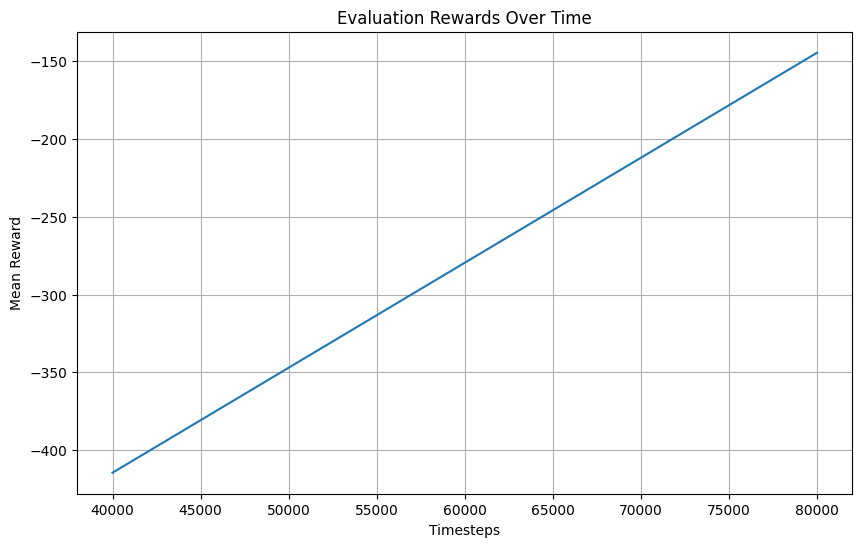

In [10]:
    plot()

In [ ]:
if __name__ == "__main__":
  display = Display(visible=0, size=(1400, 900))
  display.start()

  env_fn = basketball_pong_v3
  env_kwargs = {}
    # Evaluate 10 games (average reward should be positive but can vary significantly)
    #eval(env_fn, num_games=10, render_mode=None, **env_kwargs)
    # Watch 2 games
  eval(env_fn, num_games=2, render_mode="human", **env_kwargs)
    # Display the video after evaluation
  video_path = "/content/drive/MyDrive/2A_basket_ppo/video_100k.mp4"
  display.stop()


Starting evaluation


In [14]:
if __name__ == "__main__":
  display = Display(visible=0, size=(1400, 900))
  display.start()

  env_fn = basketball_pong_v3
  env_kwargs = {}
    # Evaluate 10 games (average reward should be positive but can vary significantly)
    #eval(env_fn, num_games=10, render_mode=None, **env_kwargs)
    # Watch 2 games
  eval_timesteps(env_fn, num_timesteps=1000, render_mode="human", **env_kwargs)
    # Display the video after evaluation
  video_path = "/content/drive/MyDrive/2A_basket_ppo/video_100k.mp4"
  display.stop()


Starting evaluation
Rewards:  {'first_0': 0, 'second_0': 0}
Avg reward: 0.0
Moviepy - Building video /content/drive/MyDrive/2A_basket_ppo/video_100k.mp4.
Moviepy - Writing video /content/drive/MyDrive/2A_basket_ppo/video_100k.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/2A_basket_ppo/video_100k.mp4
Evaluation saved as /content/drive/MyDrive/2A_basket_ppo/video_100k.mp4


In [15]:
from IPython.display import HTML
from base64 import b64encode

# Convert mp4 to base64
video_path = "/content/drive/MyDrive/2A_basket_ppo/video_100k.mp4"
video = open(video_path, "rb").read()
video_encoded = b64encode(video).decode()

# Display video
HTML(f"""
<video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
""")
